In [175]:
from datetime import time
from matplotlib import markers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from glob import glob
from seaborn import palettes
from seaborn.categorical import swarmplot
from tqdm import tqdm
import json
from scipy.signal import detrend
from scipy.ndimage import gaussian_filter1d
import os
import re
import math
import matplotlib.ticker as tck
import glob
import argparse
import statsmodels.api as sm


In [214]:
paths = glob.glob(os.path.join("E:/Turku_collab/lunagel_50s/remodelling", "**","summary_ID_level.csv"),recursive=True)
print(*paths, sep='\n')


E:/Turku_collab/lunagel_50s/remodelling\24_120\120\0_241111\241111_10um_3layer_50s_MDAMB231\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\120\0_241111\241111_10um_3layer_50s_control\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\120\1_241125\241125_10um_3layers_50s_control\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\120\1_241125\241125_10um_3layers_50s_MDAMB231\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\24\0_241107\241107_10um_3layer_50s_control\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\24\0_241107\241107_10um_3layer_50s_MDAMB231\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\24\1_241121\241121_10um_3layer_50s_MDAMB231\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\24\1_241121\241121_10um_3layer_50s_control\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodellin

In [353]:
df_list = []
data =[]
for i in paths:
    data = pd.read_csv(i)     
    parts = i.split('\\') 
    data['incubation_set'] = parts[1]
    data['incubation'] = parts[2]
    data['experiment'] = parts[3].split('_')[0]
#    data['date'] = parts[3].split('_')[1]
    data['sample'] = parts[4].split('_')[-1]
    
    max_location = data['location'].unique().max()
    for j, location in enumerate(data['location'].unique()):
        # Use .loc to properly assign values to the dataframe
        data.loc[data['location'] == location, 'gradient'] = data['y'] + j*665.6
        data.loc[data['location'] == location, 'gradient_inverse'] = data['y'] + (max_location-j)*665.6
    
    df_list.append(data)

    print(i)
    print( parts[1],parts[2],parts[3].split('_')[0],parts[4].split('_')[-1])


df = pd.concat(df_list, ignore_index=True)


E:/Turku_collab/lunagel_50s/remodelling\24_120\120\0_241111\241111_10um_3layer_50s_MDAMB231\results\summary_ID_level.csv
24_120 120 0 MDAMB231
E:/Turku_collab/lunagel_50s/remodelling\24_120\120\0_241111\241111_10um_3layer_50s_control\results\summary_ID_level.csv
24_120 120 0 control
E:/Turku_collab/lunagel_50s/remodelling\24_120\120\1_241125\241125_10um_3layers_50s_control\results\summary_ID_level.csv
24_120 120 1 control
E:/Turku_collab/lunagel_50s/remodelling\24_120\120\1_241125\241125_10um_3layers_50s_MDAMB231\results\summary_ID_level.csv
24_120 120 1 MDAMB231
E:/Turku_collab/lunagel_50s/remodelling\24_120\24\0_241107\241107_10um_3layer_50s_control\results\summary_ID_level.csv
24_120 24 0 control
E:/Turku_collab/lunagel_50s/remodelling\24_120\24\0_241107\241107_10um_3layer_50s_MDAMB231\results\summary_ID_level.csv
24_120 24 0 MDAMB231
E:/Turku_collab/lunagel_50s/remodelling\24_120\24\1_241121\241121_10um_3layer_50s_MDAMB231\results\summary_ID_level.csv
24_120 24 1 MDAMB231
E:/Turku_

In [354]:
saving_path = 'C:/Users/srboval1/OneDrive - Aalto University/Collab/Ivaska_collab/data'
df.to_csv(saving_path+'/gradients.csv')  


In [355]:

download = pd.read_csv(saving_path +'/gradients.csv', index_col=None)
print(download.columns)
download['day'] = download['day'].astype(str)



Index(['Unnamed: 0', 'day', 'sample', 'holder', 'location', 'track_id',
       'reference_id', 'distance(um)', 'Cov_Sum', 'a_(um)', 'phi_(rad)', 'c',
       'd', 'G_abs', 'radius_(m)', 'rmse', 'inv.rmse', 'shift_(s)', 'a_error',
       'phi_error', 'c_error', 'd_error', 'x', 'y', 'repeat', 'phi_(deg)',
       'tan_phi', 'incubation_set', 'incubation', 'experiment', 'gradient',
       'gradient_inverse'],
      dtype='object')


Assigning direction of gradient at which it was measured (loc1-->locx)

In [362]:
download['gradient_direction'] = np.where(
    ((download['sample'] == "MDAMB231") & (download['day'] == "241107")) | 
    (download['day'].isin(["241122","241125","241121"])),
    "stiff_to_soft",
    "soft_to_stiff"
)


In [363]:
print(download['gradient_direction'].unique())
print(download['day'].unique())
print(download['sample'].unique())


['soft_to_stiff' 'stiff_to_soft']
['241111' '241125' '241107' '241121' '241108' '241122' '241112']
['MDAMB231' 'control']


In [364]:
download.to_csv(saving_path+'/gradients.csv')  

## GLS model

In [365]:
alpha = 0.05
def GLS_g(data,ax, color):
    x= data['gradient'].values.reshape(-1,1)
    y= np.log(data['G_abs'])

    # Fit GLS model
    x_const = sm.add_constant(x)  # adds a column of ones to independent variable - allows to estimate the intercept
    
    #Fitting the model to the data
    modelGLS = sm.GLS(y,x_const)

    #Model parameters
    resultsGSL = modelGLS.fit()
    #print(resultsGSL.summary())

    #CI
    confidence_intervals = resultsGSL.conf_int(alpha=0.05)

    # Generate predictions for the original data
    x_predictedGLS = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)  # Model x-space
    x_predictedGLS_with_const = sm.add_constant(x_predictedGLS)  # Add constant for predictions

    # Prediction of y based on the model
    y_predictedGLS_log = resultsGSL.predict(x_predictedGLS_with_const)  # Get predictions
    y_predictedGLS = np.exp(y_predictedGLS_log)  # Transform back from log scale

    predictions = resultsGSL.get_prediction(x_predictedGLS_with_const)
    pred_summary = predictions.summary_frame(alpha=alpha)
    y_lower_CI = np.exp(pred_summary['obs_ci_lower'])
    y_upper_CI = np.exp(pred_summary['obs_ci_upper'])

    # CI for the predictions
    predictions = resultsGSL.get_prediction(x_predictedGLS_with_const)
    pred_summary = predictions.summary_frame(alpha=alpha)  #

    ax.scatter(data['f'],data['G_abs'],s=4, c=color) #measured from soft to stiff
    #ax.plot(x_predictedGLS, y_predictedGLS, color=color, label='Fitted Line')  # Fitted line
    #ax.fill_between(x_predictedGLS.flatten(), y_lower_CI, y_upper_CI,
                         #color=color, alpha=0.1, label='Confidence Interval')
    ax.set_ylim (0,100) 
    ax.set_xlim (0,5000)  

    #print(resultsGSL.bse)


Plotting G

set 0, 120h, MDAMB231, ['241111'],['soft_to_stiff']
set 0, 120h, control, ['241111'],['soft_to_stiff']
set 1, 120h, control, ['241125'],['stiff_to_soft']
set 1, 120h, MDAMB231, ['241125'],['stiff_to_soft']

set 0, 24h, control, ['241107'],['soft_to_stiff']
set 0, 24h, MDAMB231, ['241107'],['stiff_to_soft']
set 1, 24h, MDAMB231, ['241121'],['stiff_to_soft']
set 1, 24h, control, ['241121'],['stiff_to_soft']

set 0, 48h, control, ['241108'],['soft_to_stiff']
set 0, 48h, MDAMB231, ['241108'],['soft_to_stiff']
set 1, 48h, MDAMB231, ['241122'],['stiff_to_soft']

set 0, 144h, control, ['241112'],['soft_to_stiff']
set 0, 144h, MDAMB231, ['241112'],['soft_to_stiff']



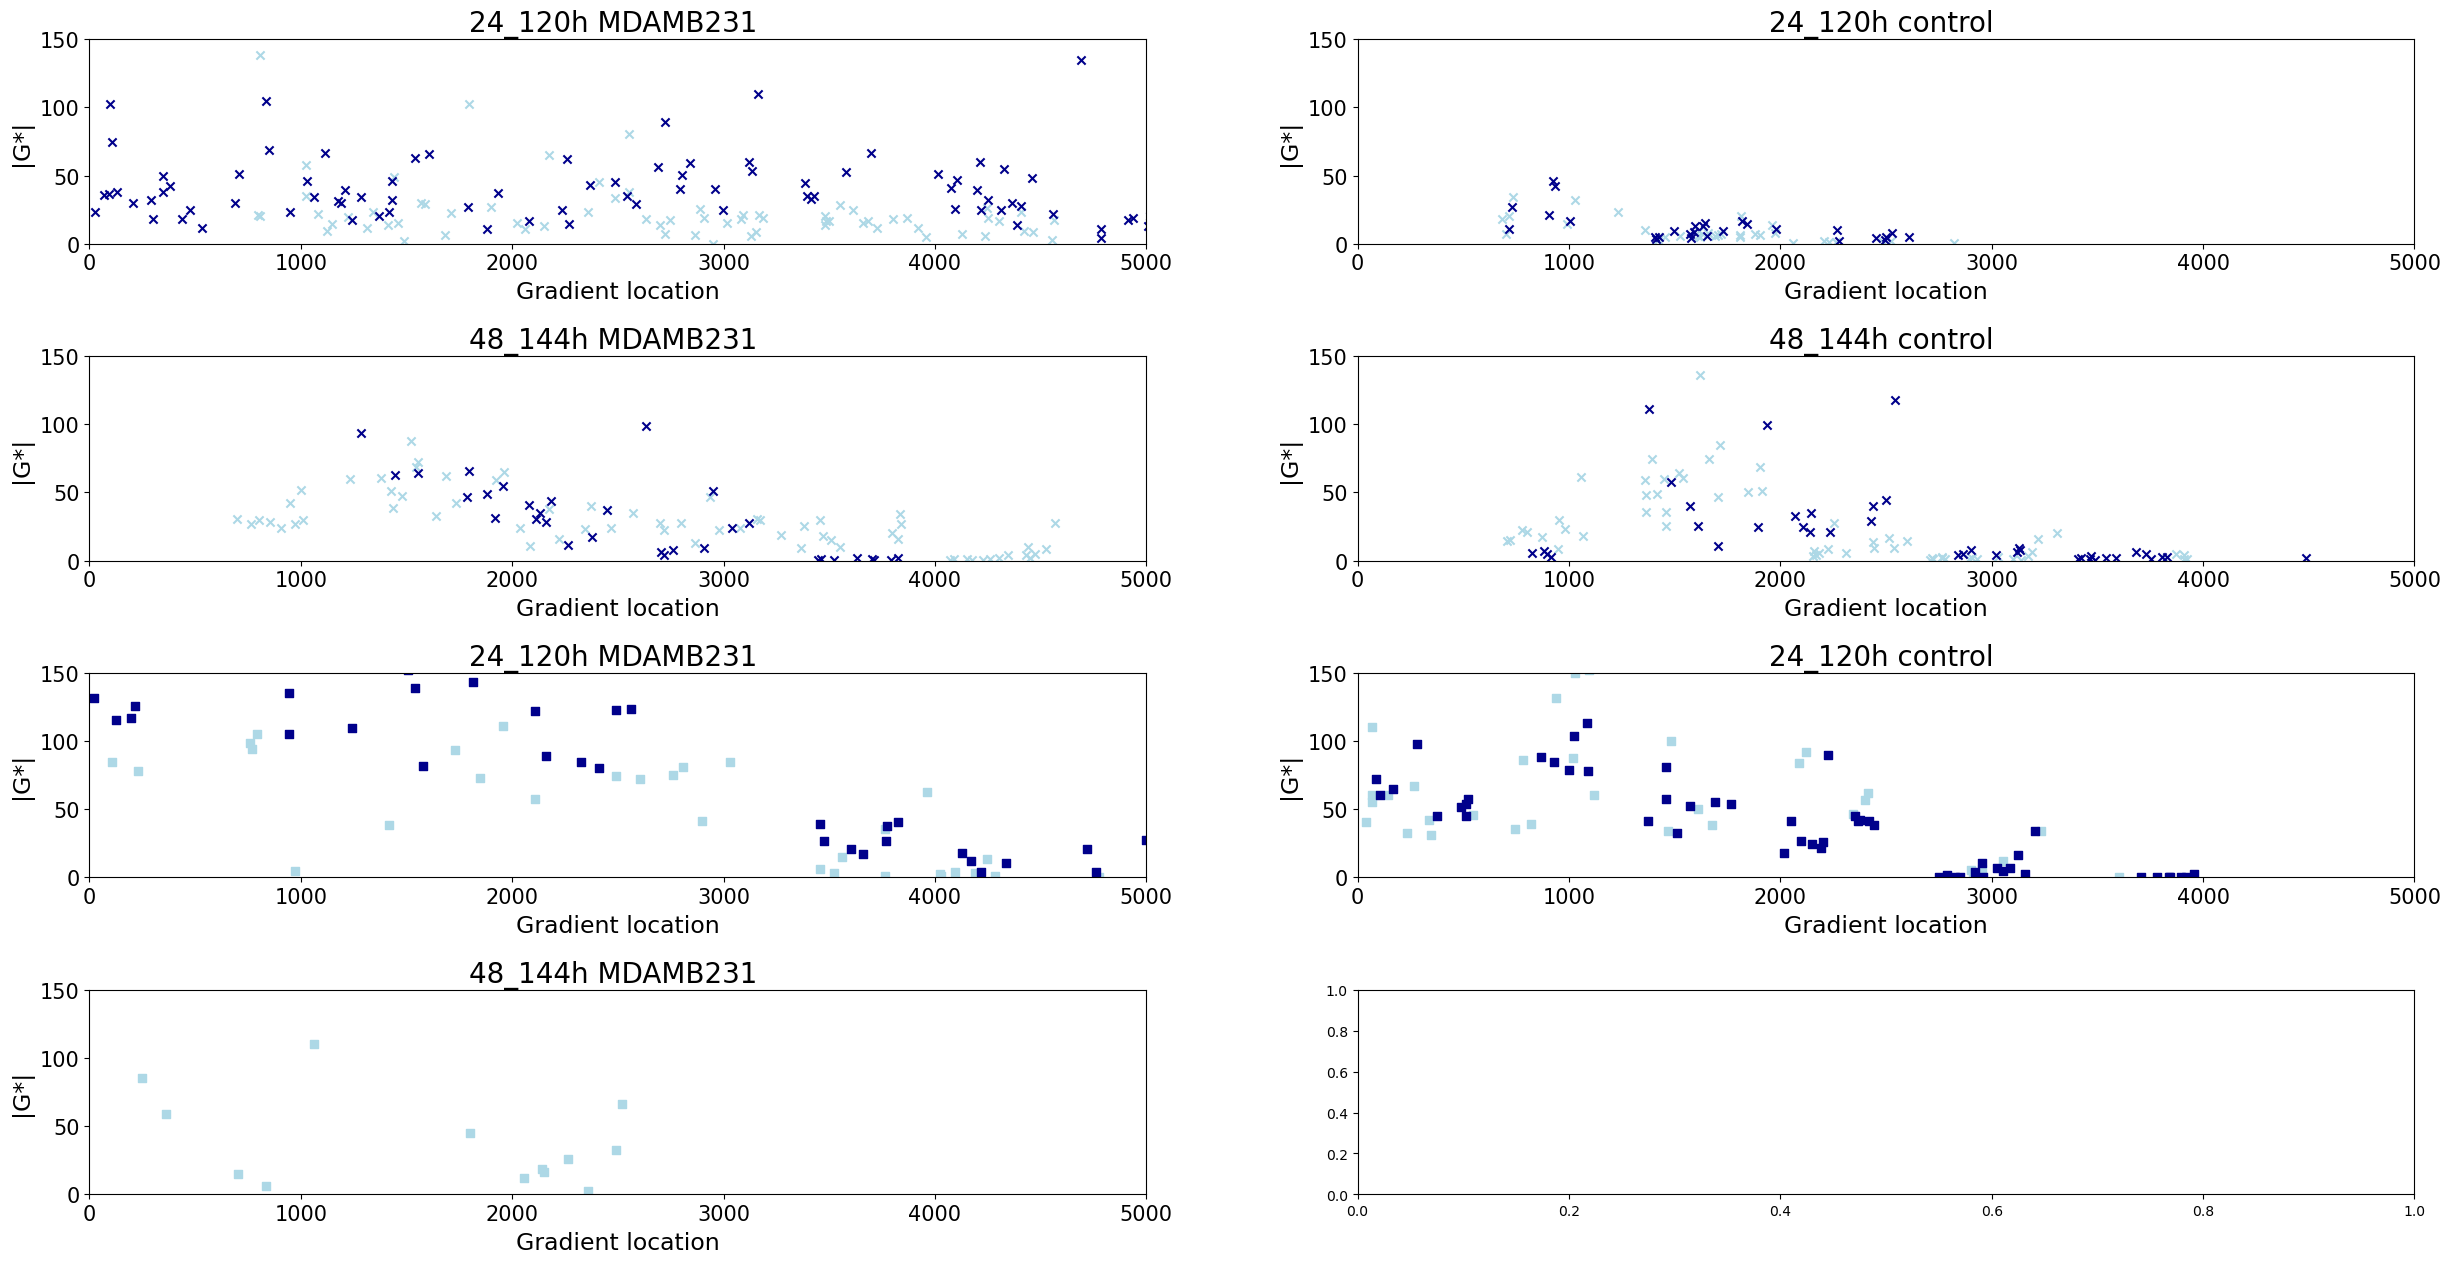

In [403]:
fig, axs = plt.subplots(4, 2, figsize=(30, 15))
plt.subplots_adjust(wspace=0.2, hspace=0.55)
fig.suptitle("", fontsize=18, y=1)

markers=['x','s']

colors = ["lightblue","darkblue"]

for i,j in enumerate(download['incubation_set'].unique()):
    first = download[download['incubation_set']==j]
        
    for nn,n in enumerate(first['incubation'].unique()):
        second = first[first['incubation']==n]
        color = colors[int(nn)]
        #print(n, color)

        
        for k,l in enumerate(second['experiment'].unique()):
            third = second[second['experiment']==l]
            marker_type = markers[l]
            row = i+(2*k)
            #print(l, marker_type)
            
            for m,o in enumerate(third['sample'].unique()):
                column = 0 if o=='MDAMB231' else 1
                fourth = third[third['sample']==o]
                print(f"set {k}, {n}h, {o}, {str(fourth['day'].unique())},{fourth['gradient_direction'].unique()}")
                date_value = str(fourth['day'].unique()[0])
                ax = axs[row,column]
                #GLS_g(dfffff,ax,color)
                #print(dfffff)
                if (fourth['gradient_direction'] == 'stiff_to_soft').all():
                    ax.scatter(fourth['gradient'],fourth['G_abs'],s=35, c=color, marker = marker_type) #measured from soft to stiff
                else:
                    ax.scatter(fourth['gradient_inverse'],fourth['G_abs'],s=35, c=color, marker=marker_type) #measured from soft to stiff

                ax.set_xlabel("Gradient location", fontsize= 17,labelpad=5)
                ax.set_ylabel("|G*|", fontsize= 17, labelpad=5)
                ax.set_title(f"{j}h {o} ", fontsize = 20)
                ax.tick_params(axis='both', labelsize=15)


                ax.set_ylim (0,150) 
                ax.set_xlim (0,5000)  
                
        print()
                

In [346]:
download.columns

Index(['Unnamed: 0', 'day', 'sample', 'holder', 'location', 'track_id',
       'reference_id', 'distance(um)', 'Cov_Sum', 'a_(um)', 'phi_(rad)', 'c',
       'd', 'G_abs', 'radius_(m)', 'rmse', 'inv.rmse', 'shift_(s)', 'a_error',
       'phi_error', 'c_error', 'd_error', 'x', 'y', 'repeat', 'phi_(deg)',
       'tan_phi', 'incubation_set', 'incubation', 'experiment', 'gradient',
       'gradient_inverse', 'gradient_direction'],
      dtype='object')

## GLS phase shift

In [205]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

alpha = 0.05

def GLS_phaseshift(data, ax, color):
    # Check for NaNs or infs in input data
    if data['f'].isnull().any() or data['phi_(rad)'].isnull().any():
        print("Data contains NaN values, which might cause issues.")
        return

    if (data['phi_(rad)'] <= 0).any():
        print("Data contains non-positive values in 'phi_(rad)', which will cause issues with log transformation.")
        return

    # Extract x and log-transform y
    x = data['f'].values.reshape(-1, 1)
    y = np.log(data['phi_(rad)'].values)

    # Fit GLS model
    x_const = sm.add_constant(x)
    modelGLS = sm.GLS(y, x_const)
    resultsGSL = modelGLS.fit()

    # Generate predictions
    x_predictedGLS = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    x_predictedGLS_with_const = sm.add_constant(x_predictedGLS)
    y_predictedGLS_log = resultsGSL.predict(x_predictedGLS_with_const)
    y_predictedGLS = np.exp(y_predictedGLS_log)

    # Prediction intervals
    predictions = resultsGSL.get_prediction(x_predictedGLS_with_const)
    pred_summary = predictions.summary_frame(alpha=alpha)
    y_lower_CI = np.exp(pred_summary['obs_ci_lower'])
    y_upper_CI = np.exp(pred_summary['obs_ci_upper'])

    # Plotting
    ax.scatter(data['f'], data['phi_(rad)'], s=4, c=color, label='Data')
    ax.plot(x_predictedGLS, y_predictedGLS, color=color, label='Fitted Line')
    ax.fill_between(x_predictedGLS.flatten(), y_lower_CI, y_upper_CI, color=color, alpha=0.1, label='Confidence Interval')
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 5000)
    ax.legend()
    ax.set_xlabel("Frequency (f)")
    ax.set_ylabel("Phase (phi in rad)")

    print("Model fit successfully. Check plot for results.")


set 0, 120h, MDAMB231, ['241111'],['soft_to_stiff']
set 0, 120h, control, ['241111'],['soft_to_stiff']
set 1, 120h, control, ['241125'],['stiff_to_soft']
set 1, 120h, MDAMB231, ['241125'],['stiff_to_soft']

set 0, 24h, control, ['241107'],['soft_to_stiff']
set 0, 24h, MDAMB231, ['241107'],['stiff_to_soft']
set 1, 24h, MDAMB231, ['241121'],['stiff_to_soft']
set 1, 24h, control, ['241121'],['stiff_to_soft']

set 0, 48h, control, ['241108'],['soft_to_stiff']
set 0, 48h, MDAMB231, ['241108'],['soft_to_stiff']
set 1, 48h, MDAMB231, ['241122'],['stiff_to_soft']

set 0, 144h, control, ['241112'],['soft_to_stiff']
set 0, 144h, MDAMB231, ['241112'],['soft_to_stiff']



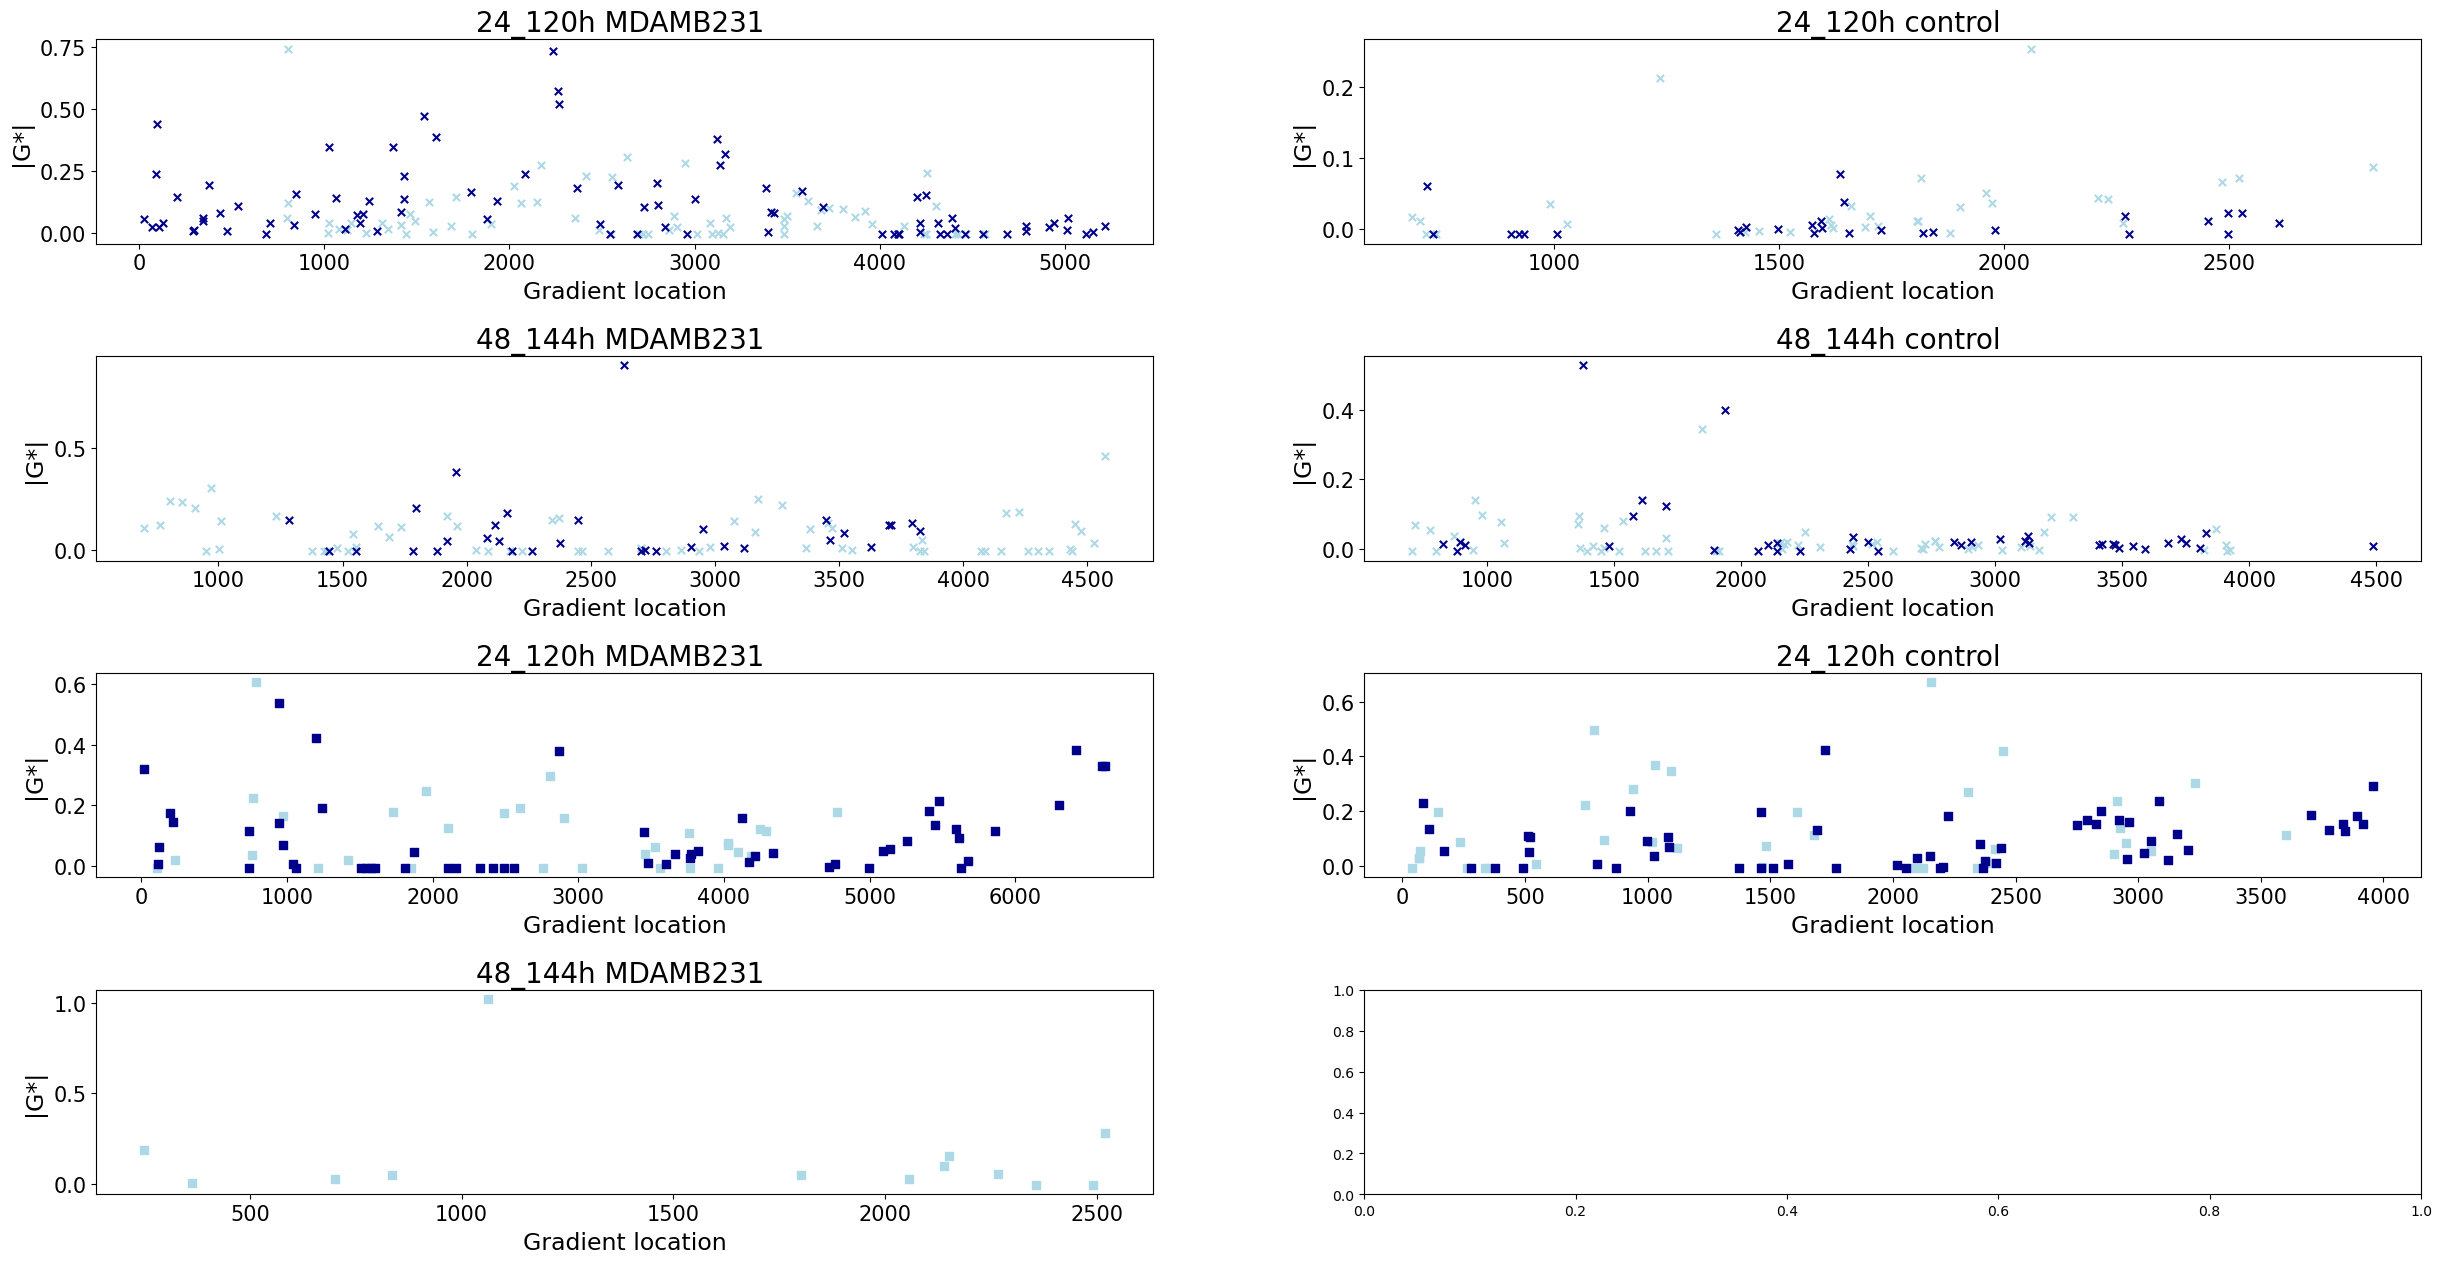

In [400]:
fig, axs = plt.subplots(4, 2, figsize=(30, 15))
plt.subplots_adjust(wspace=0.2, hspace=0.55)
fig.suptitle("", fontsize=18, y=1)

markers=['x','s']

colors = ["lightblue","darkblue"]

for i,j in enumerate(download['incubation_set'].unique()):
    first = download[download['incubation_set']==j]
        
    for nn,n in enumerate(first['incubation'].unique()):
        second = first[first['incubation']==n]
        color = colors[int(nn)]
        #print(n, color)

        
        for k,l in enumerate(second['experiment'].unique()):
            third = second[second['experiment']==l]
            marker_type = markers[l]
            row = i+(2*k)
            #print(l, marker_type)
            
            for m,o in enumerate(third['sample'].unique()):
                column = 0 if o=='MDAMB231' else 1
                fourth = third[third['sample']==o]
                print(f"set {k}, {n}h, {o}, {str(fourth['day'].unique())},{fourth['gradient_direction'].unique()}")
                date_value = str(fourth['day'].unique()[0])
                ax = axs[row,column]
                #GLS_g(dfffff,ax,color)
                #print(dfffff)
                if (fourth['gradient_direction'] == 'stiff_to_soft').all():
                    ax.scatter(fourth['gradient'],fourth['phi_(rad)'],s=28, c=color, marker = marker_type) #measured from soft to stiff
                else:
                    ax.scatter(fourth['gradient_inverse'],fourth['phi_(rad)'],s=28, c=color, marker=marker_type) #measured from soft to stiff

                ax.set_xlabel("Gradient location", fontsize= 17,labelpad=5)
                ax.set_ylabel("|G*|", fontsize= 17, labelpad=5)
                ax.set_title(f"{j}h {o} ", fontsize = 20)
                ax.tick_params(axis='both', labelsize=15)


                # ax.set_ylim (0,200) 
                # ax.set_xlim (0,5000)  
                
        print()
                

Text(0.5, 1.0, 'Cell sample 24h')

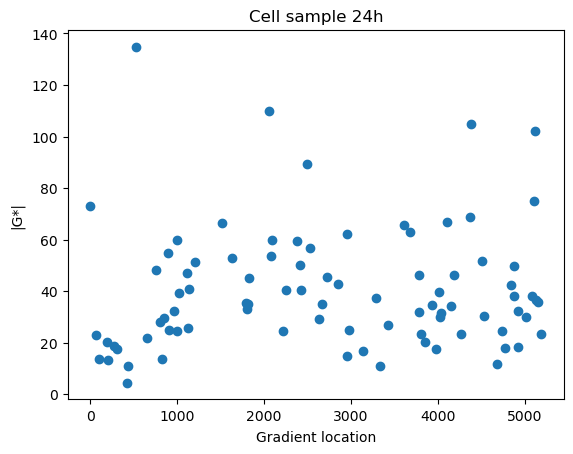

In [ ]:
plt.scatter(df['x_con'],df['G_abs'])
plt.xlabel("Gradient location", fontsize= 10,labelpad=5)
plt.ylabel("|G*|", fontsize= 10, labelpad=5)
plt.title('Cell sample 24h')


Text(0.5, 1.0, 'Control sample 24h')

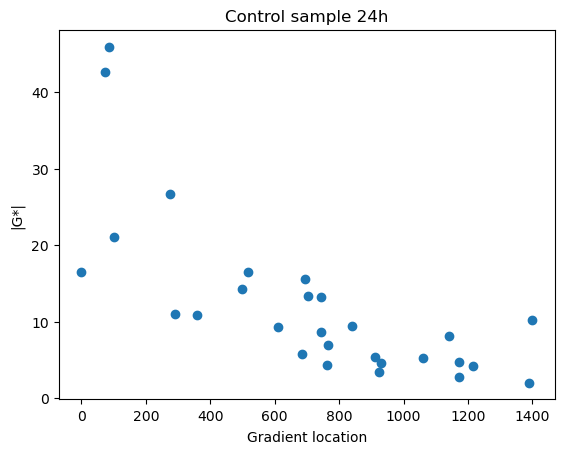

In [9]:
max = control['gradient'].max()
control['x_con'] = max -control['gradient']
control.to_csv('C:/Users/srboval1/OneDrive - Aalto University/Collab/Ivaska_collab/data/241107_24h_control', index=False)

plt.scatter(control['x_con'],control['G_abs'])
plt.xlabel("Gradient location", fontsize= 10,labelpad=5)
plt.ylabel("|G*|", fontsize= 10, labelpad=5)
plt.title('Control sample 24h')